# Federated Machine Learning in PyTorch

This notebook is a demonstration of _federated learning_, an approach to training a machine learning model by combining the results of training local models on multiple devices.

This notebook is part of a series intended to start from the basics to demonstrate federated learning in `pytorch`, then move on to test some of the bounds of what federated learning can (and can't) do.

## The Task: Digit Recognition

For this demonstration, our task is a classic one: the MNIST digit recognition task. Specifically, we need to determine which number is written in an image of a handwritten digit like this one: 

![Handwritten digit "6"](images/example-6.png)

To carry out this task we need a machine learning model to "look" at an image and classify it into a number. We also need and image data to train the model. We're going to use a simple convolutional neural network model. For the training images, we're using the well-known MNIST digits dataset.

## The Approach: Federation

The federated approach uses several _worker_ devices to train their own local models with independent data. That is, the workers each train their own local model with a subset of the full dataset.

Each worker trains its local model for a bit, then sends its incrementally trained local model back to a _manager_. The manager combines the local models from all of the workers into a master model, then sends the master model back to the workers. This process is called a _round_. 

Then another round begins: the workers each train their local copy of the master model (creating another set of individualized local models), send those local models back to the manager. Once again the manager combines these individualized local models into a new master model, and pushes the new master model down to the workers. This cycle of rounds repeats as long as is necessary and useful.

## Our Federation Library

The `federated` library we're using here is a *simulation* of a federated network. It's not *true* federated learning because it uses one machine to simulate several indepedent machines. This means it does not have to deal with network communication or the timing problems inherent to parallelism. But the "local" models are independent and that is sufficient to demonstrate the principles underlying federated learning.

Our library includes a `FederatedManager` class and a `FederatedWorker` class. A `FederatedManager` contains a master prediction model and creates several independent `FederatedWorker` instances. Each `FederatedWorker` has its own local model and a distinct subset of the MNIST data.

In each `round` of federated learning, each `FederatedWorker` trains its local model using only the data that that worker recieves, and then sends its trained local model to the `FederatedManager`. The `FederatedManager` combines the models into an updated master model and pushes that new master model down to each `FederatedWorker`. There are a number of algorithms available for combining local models. Our library uses [federated averaging](https://arxiv.org/abs/1602.05629), a very simple element-by-element average of the model's weights.

We're going to see how federation works and test out some corner cases here. Let's get started with the code.

## The Model

Now we define the model. We're using the [sample model from the `pytorch` package](https://github.com/pytorch/examples/blob/master/mnist/main.py).

In [1]:
# Define the model

import torch.nn as nn
import torch.nn.functional as F

'''   

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST data, a training set and a test set, from the `pytorch` package, again using the same transforms as their example.

If you don't already have the MNIST data on your machine, the setting `download=True` in the call to `torchvision.datasets.MNIST()` will fetch it for you.

In [2]:
# acquire the data and create standard MNIST datasets

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data
data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

print("Train dataset size: ", len(train_dset))
print("Test dataset size : ", len(test_dset))

Train dataset size:  60000
Test dataset size :  10000


Now we have our standard MNIST datasets: `train_dset` contains 60,000 examples, and `test_dset` contains 10,000 samples.

In [3]:
# create dataloaders

from torch.utils.data import DataLoader

train_batch_size = 64
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dloader = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

Let's check out the default data. The out-of-the-box MNIST dataset has roughly equal numbers of samples for each digit, i.e., about as many `4`s as `6`s.

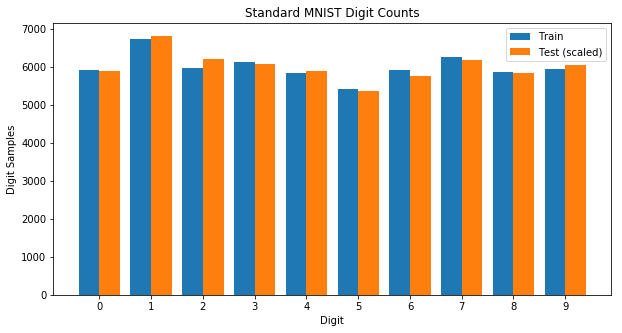

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Standard MNIST Digit Counts')
ax.set_xlabel('Digit')
ax.set_ylabel('Digit Samples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

The training data is reasonably well distributed, and the plots above confirm it. We scaled up the test set counts by a factor of six to make them comparable to the training set, which has exactly six times as many examples as the test set.

## Baseline: The Non-Federated Approach

To show a baseline of non-federated learning, we train a model using just one worker (we're technically using the federated library, but with one worker, it's equivalent to non-federated learning). This one worker will train on the full standard MNIST dataset of 60,000 examples.

TODO: AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

TODO: Explain (and apologize?) the hack to measure the length of a dataset? Or find another way?

In [5]:
import federated

learning_rate = 5e-2
num_epochs = 1
num_rounds = 20

default_manager = federated.FederatedManager(
    [train_dloader],
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

print("Dataset size: ", len(train_dloader.dataset))

Dataset size:  60000


In [6]:
from tqdm.notebook import trange

def run_manager(manager, num_rounds):
    
    print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", manager.n_epochs, "epoch(s) per round.\n" )

    for i in trange(num_rounds, desc='Rounds'):
        print("Beginning round", i+1)
        manager.round()
        print("Finished round", i+1, "with global loss: %.5f and accuracy: %.2f" % (
            manager.history['test_loss'][-1], 
            manager.history['test_acc'][-1]
        ), "\n")
        
run_manager(default_manager, num_rounds)

Training 20 round(s) with 1 worker(s) doing 1 epoch(s) per round.



Beginning round 1
0 0.11971 96.42
Finished round 1 with global loss: 0.11971 and accuracy: 96.42 

Beginning round 2
0 0.09930 96.78
Finished round 2 with global loss: 0.09930 and accuracy: 96.78 

Beginning round 3
0 0.07169 97.64
Finished round 3 with global loss: 0.07169 and accuracy: 97.64 

Beginning round 4
0 0.06405 97.90
Finished round 4 with global loss: 0.06405 and accuracy: 97.90 

Beginning round 5
0 0.05631 98.23
Finished round 5 with global loss: 0.05631 and accuracy: 98.23 

Beginning round 6
0 0.06118 98.11
Finished round 6 with global loss: 0.06118 and accuracy: 98.11 

Beginning round 7
0 0.06396 98.18
Finished round 7 with global loss: 0.06396 and accuracy: 98.18 

Beginning round 8
0 0.05647 98.35
Finished round 8 with global loss: 0.05647 and accuracy: 98.35 

Beginning round 9
0 0.05916 98.16
Finished round 9 with global loss: 0.05916 and accuracy: 98.16 

Beginning round 10
0 0.06589 98.15
Finished round 10 with global loss: 0.06589 and accuracy: 98.15 

Beginnin

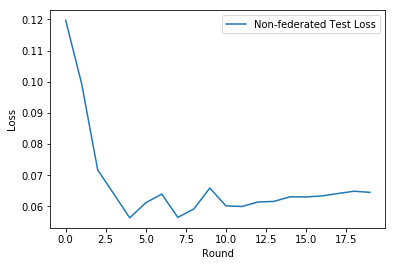

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig_default, ax_default = plt.subplots()

ax_default.plot(default_manager.history['test_loss'], label="Non-federated Test Loss")

ax_default.set_xlabel("Round")
ax_default.set_ylabel("Loss")
ax_default.legend();

# The Federated Approach

Now that we have a baseline using the traditional approach. we perform the same task using the federated learning approach.

## Splitting the Deck Into Piles

To illustrate federated learning we use several workers, each representing a device in the field. For now, we'll assume our workers are exposed to similar types and amounts of data, say, a thermostat reporting temperature and humidity every ten minutes. The analog here in MNIST is a subset of training examples for each worker. Here, we'll use ten workers. Our `pytorch` implementation will create a training `DataLoader` for each worker (and we we'll leave the test `DataLoader` as it is in the raw MNIST `Dataset`.

In [8]:
#from torch.utils.data import WeightedRandomSampler
#whitmans_sampler = WeightedRandomSampler([0.2, 0.14, 0.19], 24, replacement=False)

from torch.utils.data import RandomSampler

num_workers = 10
samples_per_worker = 6000
fed_constant_n_dloaders = []

fed_constant_n_sampler = RandomSampler(
    data_source=train_dset,
    replacement= True,
    num_samples=samples_per_worker,
    )

for i in trange(num_workers):
    fed_constant_n_dloaders.append(DataLoader(
        train_dset, 
        batch_size=train_batch_size, 
        sampler=fed_constant_n_sampler,
    ))

In [9]:
for i in trange(len(fed_constant_n_dloaders), desc='Checking Dataloader Sizes: '):
    _, ybatches = list(zip(*fed_constant_n_dloaders[7]))
    print('Dataloader', i, 'sample count:', len(torch.cat(ybatches)))

Dataloader 0 sample count: 6000
Dataloader 1 sample count: 6000
Dataloader 2 sample count: 6000
Dataloader 3 sample count: 6000
Dataloader 4 sample count: 6000
Dataloader 5 sample count: 6000
Dataloader 6 sample count: 6000
Dataloader 7 sample count: 6000
Dataloader 8 sample count: 6000
Dataloader 9 sample count: 6000



In [10]:
from collections import Counter
import numpy as np
from tqdm.notebook import tqdm

hist_counts = []
digit_counts = []
for loader in tqdm(fed_constant_n_dloaders, desc='Getting Digit Counts:'):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

In [11]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(digit_counts)

print(fed_constant_n_dloaders[0].dataset.__len__)

for i in range(len(fed_constant_n_dloaders)):
    
    print(sum(digit_counts[i]))
    

[   [627, 596, 566, 591, 590, 587, 643, 576, 589, 596],
    [682, 655, 686, 664, 648, 661, 644, 647, 672, 650],
    [594, 651, 586, 591, 590, 587, 566, 616, 563, 598],
    [587, 565, 630, 640, 605, 625, 651, 628, 663, 633],
    [602, 608, 564, 588, 590, 569, 523, 566, 572, 586],
    [494, 599, 541, 531, 573, 541, 530, 514, 559, 549],
    [597, 597, 589, 598, 618, 579, 609, 625, 571, 600],
    [629, 584, 645, 622, 643, 654, 657, 638, 623, 619],
    [571, 529, 575, 553, 576, 551, 582, 608, 597, 583],
    [617, 616, 618, 622, 567, 646, 595, 582, 591, 586]]
<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./MNIST-data/raw
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None>
5961
6609
5942
6227
5768
5431
5983
6314
5725
6040


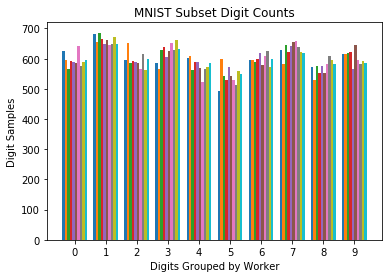

In [12]:
fig, ax = plt.subplots()
ax.set_title('MNIST Subset Digit Counts')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylabel('Digit Samples')
ax.set_xlabel('Digits Grouped by Worker')
H = ax.hist(hist_counts, bins=range(11), histtype='bar', align='left', rwidth=0.8)


##TODO CONFIRM WHAT IM SEEING HERE

So we can see that each of our ten workers has about the same number of each digit, i.e., the digit `5` is spread pretty evenly across the workers, and is probably lower in number for any given worker than the digit `1`, `1` being the most frequent digit in the MNIST set.

In [13]:
import federated

fed_constant_n_manager = federated.FederatedManager(
    fed_constant_n_dloaders,
    Net,
    nn.CrossEntropyLoss(),
    test_dset,
    num_epochs,
    learning_rate
)

run_manager(fed_constant_n_manager, num_rounds)

Training 20 round(s) with 10 worker(s) doing 1 epoch(s) per round.



Beginning round 1
0 0.35250 89.70
1 0.37223 89.09
2 0.34810 90.16
3 0.36148 89.37
4 0.36313 89.49
5 0.38600 88.24
6 0.36560 89.57
7 0.38525 88.69
8 0.37932 88.50
9 0.37583 88.66
Finished round 1 with global loss: 0.32671 and accuracy: 90.75 

Beginning round 2
0 0.28913 91.57
1 0.31646 90.60
2 0.31703 90.60
3 0.27469 91.73
4 0.28574 91.77
5 0.28216 91.69
6 0.27894 91.64
7 0.28766 91.00
8 0.28546 91.78
9 0.27490 91.51
Finished round 2 with global loss: 0.25208 and accuracy: 92.62 

Beginning round 3
0 0.24608 92.56
1 0.26507 92.19
2 0.23708 93.09
3 0.23778 92.82
4 0.23495 92.66
5 0.26113 92.27
6 0.23836 92.74
7 0.27458 91.95
8 0.24494 92.58
9 0.24396 92.48
Finished round 3 with global loss: 0.21074 and accuracy: 93.78 

Beginning round 4
0 0.20893 93.48
1 0.20961 93.47
2 0.20253 93.76
3 0.20956 93.73
4 0.19912 94.06
5 0.19477 94.00
6 0.21162 93.38
7 0.19875 93.87
8 0.20411 94.19
9 0.20142 93.91
Finished round 4 with global loss: 0.17919 and accuracy: 94.69 

Beginning round 5
0 0.19187 

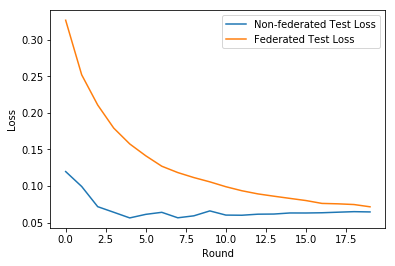

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig_default, ax_default = plt.subplots()

ax_default.plot(default_manager.history['test_loss'], label="Non-federated Test Loss")

ax_default.plot(fed_constant_n_manager.history['test_loss'], label="Federated Test Loss")

ax_default.set_xlabel("Round")
ax_default.set_ylabel("Loss")
ax_default.legend();

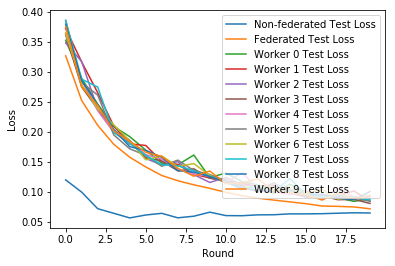

In [15]:
fig, ax = plt.subplots()

ax.plot(default_manager.history['test_loss'], label="Non-federated Test Loss")

ax.plot(fed_constant_n_manager.history['test_loss'], label="Federated Test Loss")

for w in fed_constant_n_manager.workers:
    ax.plot(w.history['test_loss'], label=('Worker ' + str(w.name) + ' Test Loss'))

ax.set_xlabel("Round")
ax.set_ylabel("Loss")
ax.legend();

# Federation with Varying Example Counts

Now we've seen federation work with a dataset scattered across a number of workers. And we saw that its performance isn't substantially different from the non-federated approach, while decentralizing the work of training and limiting the amount of data transfered between the main manager and the workers.

But what if our workers don't have access to equal amounts of data? Let's explore that.

## Spliting the Deck into Uneven Piles

To test this, we need workers to have access to different numbers of training examples. So let's make a set of decks that gives each of our workers more or less training data than the others.

# Conclusion
TODO: WRAP UP THE BLOG POST HERE. EVERYTHING BELOW IS PART TWO OR THREE